## Fine Tuning the ViT on CIFAR10

using a model that is pre-trained on ImageNet-21k, a dataset of 14M labeled images

- Load the Dataset

In [8]:
!python --version

Python 3.9.19


In [1]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [2]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [3]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [4]:
train_ds.features

{'img': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

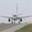

In [5]:
train_ds[0]['img']

In [6]:
train_ds[0]['label']

0

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
id2label[train_ds[0]['label']]

'airplane'

- Data Preprocessing

In [9]:

from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

In [10]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [11]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [12]:
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0,
 'pixel_values': tensor([[[0.5765, 0.5765, 0.5765,  ..., 0.5686, 0.5686, 0.5686],
          [0.5765, 0.5765, 0.5765,  ..., 0.5686, 0.5686, 0.5686],
          [0.5765, 0.5765, 0.5765,  ..., 0.5686, 0.5686, 0.5686],
          ...,
          [0.5529, 0.5529, 0.5529,  ..., 0.4510, 0.4510, 0.4510],
          [0.5529, 0.5529, 0.5529,  ..., 0.4510, 0.4510, 0.4510],
          [0.5529, 0.5529, 0.5529,  ..., 0.4510, 0.4510, 0.4510]],
 
         [[0.6314, 0.6314, 0.6314,  ..., 0.6235, 0.6235, 0.6235],
          [0.6314, 0.6314, 0.6314,  ..., 0.6235, 0.6235, 0.6235],
          [0.6314, 0.6314, 0.6314,  ..., 0.6235, 0.6235, 0.6235],
          ...,
          [0.5451, 0.5451, 0.5451,  ..., 0.4510, 0.4510, 0.4510],
          [0.5451, 0.5451, 0.5451,  ..., 0.4510, 0.4510, 0.4510],
          [0.5451, 0.5451, 0.5451,  ..., 0.4510, 0.4510, 0.4510]],
 
         [[0.6941, 0.6941, 0.6941,  ..., 0.6863, 0.6863, 0.6863],
        

In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


- Define Model

In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test200epoch-cifar-10_1",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=8e-4,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=200,
    weight_decay=0.1,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/home/cvmlserver1/.local/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [18]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

- Train

In [19]:
trainer.train()

/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.328487,0.895800
2,No log,0.318612,0.895400
3,0.704900,0.234539,0.921800
4,0.704900,0.277564,0.914400
5,0.482000,0.241023,0.918000
6,0.482000,0.221006,0.927600
7,0.440200,0.269603,0.912000
8,0.440200,0.245516,0.920800
9,0.410100,0.216286,0.933600
10,0.410100,0.212187,0.932000


/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimensi

- Evaluation

In [ ]:
outputs = trainer.predict(test_ds)

/home/cvmlserver1/.local/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
print(outputs.metrics)

{'test_loss': 0.6724695563316345, 'test_accuracy': 0.859, 'test_runtime': 80.2875, 'test_samples_per_second': 124.552, 'test_steps_per_second': 10.388}


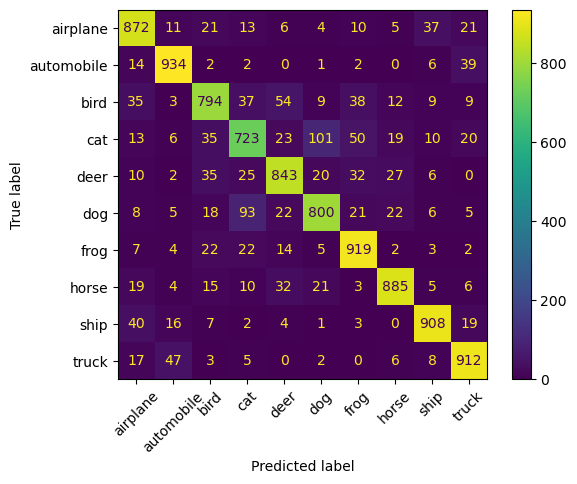

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)